In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import dodiscover as dod
import hyppo
import scipy as sp
import sklearn as sk
from sims import *

import matplotlib.gridspec as gridspec

# code taken from https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

# ATE Sims

In [2]:
%%script false --no-raise-error

n = 100
p=101
sims = {"Sigmoidal": sigmoidal_sim, "Linear": linear_sim, "K-Class": kclass_sim}

data_samples = []
data_true = []
for sim, sim_fn in sims.items():
    Ys, Ts, Xs, true_y, true_t, true_x = sim_fn(n, p, causal_effect_size=2, balance=.4)
    df = pd.DataFrame({"Class": Ts, "Measurement" : Ys[:,0], "y2": Ys[:,p-1], "Covariate" : Xs, "Balance":"Unmatched", "Simulation":sim})
    df_true = pd.DataFrame({"Class" : true_t, "Measurement" : true_y[:, 0], "y2" : true_y[:, p-1], "Covariate" : true_x, "Simulation":sim})
    
    balanced_ids = causal_prep(Xs, Ts)
    Xs_bal = Xs[balanced_ids]; Ts_bal = Ts[balanced_ids]; Ys_bal = Ys[balanced_ids,:]
    df_bal = pd.DataFrame({"Class": Ts_bal, "Measurement" : Ys_bal[:,0], "y2": Ys_bal[:,p-1], "Covariate" : Xs_bal, "Balance":"Matched", "Simulation":sim})
    
    data_samples.append(pd.concat((df, df_bal)))
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

In [3]:
%%script false --no-raise-error

def make_subplot(df_dat, df_true, title=""):
    fig = plt.figure(constrained_layout=True);
    widths = [2, .5]
    heights = [.5, 2]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights);
    
    ax = fig.add_subplot(spec[0, 0]);
    palette=sns.color_palette("deep", 3)
    g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Class", palette=palette, legend=False, binwidth=0.1)
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, xlim=(-1, 1))
    ax = fig.add_subplot(spec[1, 0]);
    g = sns.scatterplot(data=df_dat, x="Covariate", y="Measurement", hue="Class", ax=ax, alpha=0.5, palette=palette)
    ax.set_xlim(-1, 1)
    
    ylim = (np.min((np.min(df_true["Measurement"]), np.min(df_dat["Measurement"]))), np.max((np.max(df_true["Measurement"]), np.max(df_dat["Measurement"]))))
    sns.lineplot(data=df_true, x="Covariate", y="Measurement", hue="Class", ax=ax, linewidth=3, palette=palette, legend=False)
    ax = fig.add_subplot(spec[1, 1]);
    g = sns.histplot(data=df_dat, y="Measurement", ax=ax, hue="Class", palette=palette, legend=False, bins=20, orientation="horizontal")
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, ylim=ylim)
    
    
    return fig


df_dat = data_samples[(data_samples["Simulation"] == "Linear") & (data_samples["Balance"] == "Unmatched")]
df_tru = data_true[data_true["Simulation"] == "Linear"]
g11 = make_subplot(data_samples[(data_samples["Simulation"] == "Linear") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Linear"])
g21 = make_subplot(data_samples[(data_samples["Simulation"] == "Linear") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Linear"])
g12 = make_subplot(data_samples[(data_samples["Simulation"] == "Sigmoidal") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Sigmoidal"])
g22 = make_subplot(data_samples[(data_samples["Simulation"] == "Sigmoidal") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Sigmoidal"])
g13 = make_subplot(data_samples[(data_samples["Simulation"] == "K-Class") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "K-Class"])
g23 = make_subplot(data_samples[(data_samples["Simulation"] == "K-Class") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "K-Class"])

# CATE Sims

In [24]:
n = 2000
p=10
pref = 0
sims = {"Rotation": sigmoidal_sim_cate, "Non-Monotone": nonmonotonic_sim_cate, "Rotation-K": kclass_rotation_cate}

data_samples = []
data_true = []
for sim, sim_fn in sims.items():
    Ys, Ts, Xs, true_y, true_t, true_x = sim_fn(n, p, causal_effect_size=1, covar_effect_size = 1, balance=.4)
    df = pd.DataFrame({"Class": Ts, "Measurement" : Ys[:,pref], "Covariate" : Xs, "Balance":"Unmatched", "Simulation":sim})
    df_true = pd.DataFrame({"Class" : true_t, "Measurement" : true_y[:, pref], "Covariate" : true_x, "Simulation":sim})
    
    balanced_ids = causal_prep(Xs, Ts)
    Xs_bal = Xs[balanced_ids]; Ts_bal = Ts[balanced_ids]; Ys_bal = Ys[balanced_ids,:]
    df_bal = pd.DataFrame({"Class": Ts_bal, "Measurement" : Ys_bal[:,pref], "Covariate" : Xs_bal, "Balance":"Matched", "Simulation":sim})
    
    data_samples.append(pd.concat((df, df_bal)))
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

Optimization terminated successfully.
         Current function value: 0.389649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.755715
         Iterations 7


/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_69088/2210207904.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Class", palette=palette, legend=False, binwidth=0.1)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_69088/2210207904.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.scatterplot(data=df_dat, x="Covariate", y="Measurement", hue="Class", ax=ax, alpha=0.5, palette=palette)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_69088/2210207904.py:16: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=df_true, x="Covariate", y="Measurement", hue="Class", ax=ax, linewidth=3, palette=palette, legend=False)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_69088/2210207904.py:18: UserWarning: The palette list has m

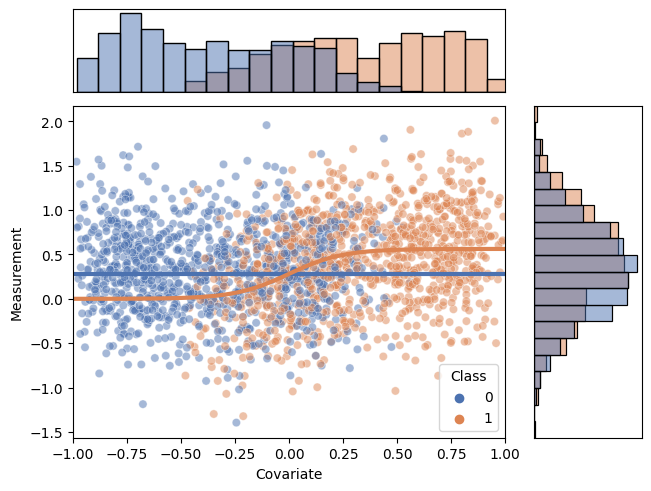

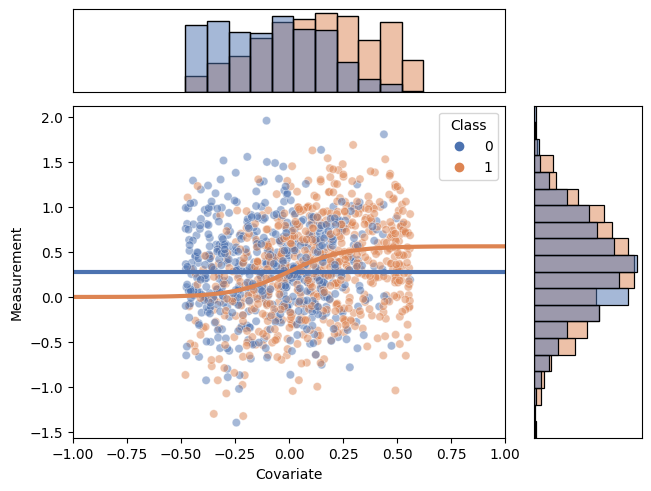

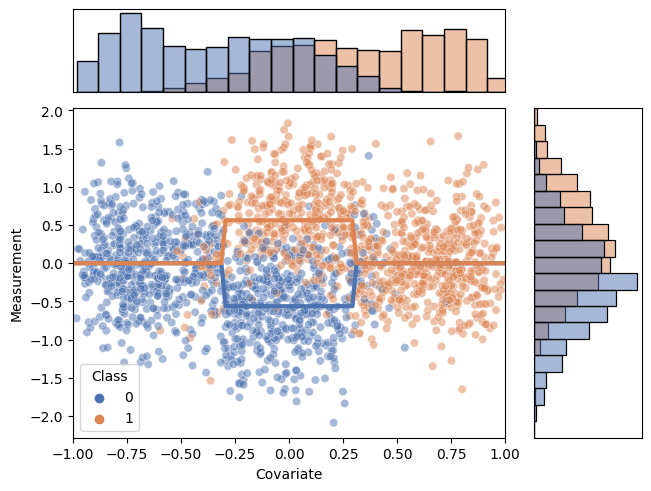

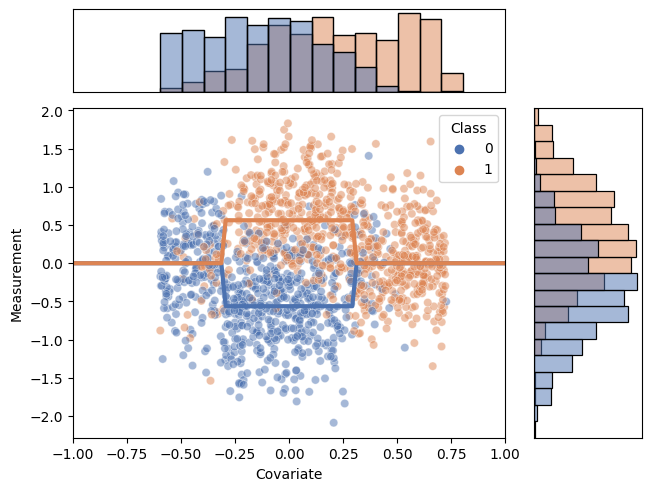

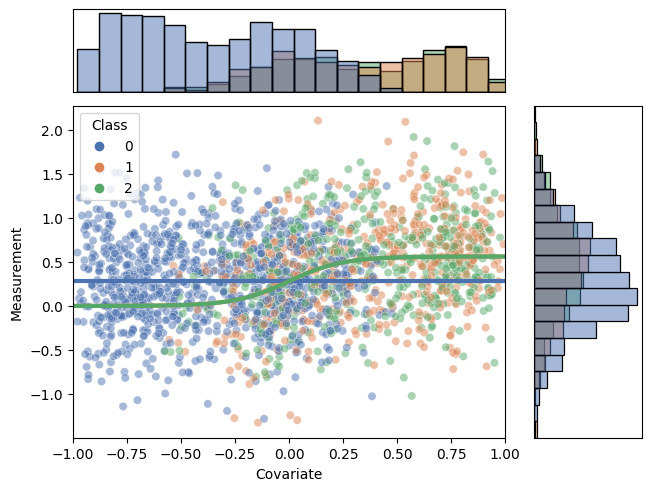

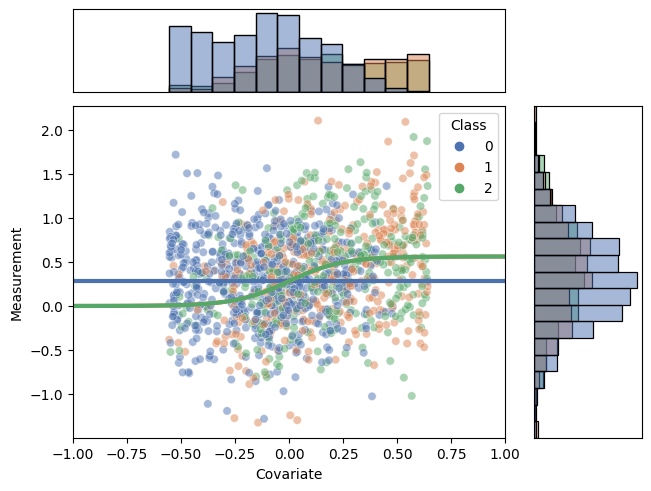

In [25]:
def make_subplot(df_dat, df_true, title=""):
    fig = plt.figure(constrained_layout=True);
    widths = [2, .5]
    heights = [.5, 2]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights);
    
    ax = fig.add_subplot(spec[0, 0]);
    palette=sns.color_palette("deep", 3)
    g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Class", palette=palette, legend=False, binwidth=0.1)
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, xlim=(-1, 1))
    ax = fig.add_subplot(spec[1, 0]);
    g = sns.scatterplot(data=df_dat, x="Covariate", y="Measurement", hue="Class", ax=ax, alpha=0.5, palette=palette)
    ax.set_xlim(-1, 1)
    
    ylim = (np.min((np.min(df_true["Measurement"]), np.min(df_dat["Measurement"]))), np.max((np.max(df_true["Measurement"]), np.max(df_dat["Measurement"]))))
    sns.lineplot(data=df_true, x="Covariate", y="Measurement", hue="Class", ax=ax, linewidth=3, palette=palette, legend=False)
    ax = fig.add_subplot(spec[1, 1]);
    g = sns.histplot(data=df_dat, y="Measurement", ax=ax, hue="Class", palette=palette, legend=False, bins=20, orientation="horizontal")
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, ylim=ylim)
    
    
    return fig

g11 = make_subplot(data_samples[(data_samples["Simulation"] == "Rotation") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Rotation"])
g21 = make_subplot(data_samples[(data_samples["Simulation"] == "Rotation") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Rotation"])
g12 = make_subplot(data_samples[(data_samples["Simulation"] == "Non-Monotone") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Non-Monotone"])
g22 = make_subplot(data_samples[(data_samples["Simulation"] == "Non-Monotone") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Non-Monotone"])
g13 = make_subplot(data_samples[(data_samples["Simulation"] == "Rotation-K") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Rotation-K"])
g23 = make_subplot(data_samples[(data_samples["Simulation"] == "Rotation-K") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Rotation-K"])